# <font size=20px>A&A Demand Transfer HackOverflow Challenge</font>
# <font color='red'>TII</font> - The Infinity Innovators

## Flow chart
![flow.png](attachment:flow.png)

In [ ]:
""" install and import required libraries """

!pip install fuzzywuzzy
!pip install plotly
!pip install gensim
!pip install webcolors
!pip install matplotlib
!pip install openpyxl
!pip install spacy
!pip install seaborn
!python -m spacy download en_core_web_sm
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')
from gensim.parsing.preprocessing import remove_stopwords
import string
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import webcolors
import nltk
nltk.download('punkt')
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV
from fuzzywuzzy import fuzz
from sklearn.cluster import KMeans
from difflib import SequenceMatcher
import spacy
import glob
import os
import time
nlp = spacy.load('en_core_web_sm')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 6.0 MB/s eta 0:00:00m eta 0:00:010:00:01m
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


[nltk_data] Downloading package punkt to /Users/Z00BRN6/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# <font size=30px>Defining all necessary functions</font>

In [ ]:
#Preprocess Data

def text_preprocessing(text):
    text = text.lower()
    words = text.split()
    words = [word.strip('.,!;()[]') for word in words]
    words = [word.replace("'s", '') for word in words]
    unique = ""
    for word in words:
        if word not in unique:
            unique=unique+word
    return unique

def load_data(dataset):
    df = pd.read_csv(dataset)
    df = df.reset_index()
    new_data=[]
    for i in range(len(df)):
        s=text_preprocessing(df['attribute_key_value_pairs'][i])
        new_data.append(s)
    df = df.assign(preprocessed_data=new_data)
    df = df.filter(['index','tcin','fixed_attributes','preprocessed_data'], axis=1)
    return df

def stemSentence(sentence):
    porter = PorterStemmer()
    token_words = word_tokenize(sentence)
    stem_sentence = [porter.stem(word) for word in token_words]
    return ' '.join(stem_sentence)


In [ ]:
#Data Visualization and identification of number of clusters

def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(6, 5, figsize=(50, 50), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.5)
        ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)
    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

def visualize_clusters_required(text1):
    #Remove stopwords, punctuation and numbers using gensim and string libraries
    text2 = [remove_stopwords(x)\
            .translate(str.maketrans('','',string.punctuation))\
            .translate(str.maketrans('','',string.digits))\
            for x in text1]
    text3 = pd.Series([stemSentence(x) for x in text2])

    #Bag of words
    vectorizer_cv = CountVectorizer(analyzer='word')
    X_cv = vectorizer_cv.fit_transform(text3)

    #Test increments of 100 clusters using elbow method
    sse={}
    for k in np.arange(100,900,100):
        kmeans = KMeans(n_clusters=k, max_iter=1000).fit(X_cv)
        sse[k] = kmeans.inertia_
    plt.plot(list(sse.keys()),list(sse.values()))
    plt.xlabel('Values for K')
    plt.ylabel('SSE')
    plt.show()

def find_cluster(char, lst):
    for x in range(len(lst)):
        try:
            idx = lst[x].index(char)
            return x
        except ValueError:
            pass
    return None


In [ ]:
#Clustering, Text Similarity and Scoring

def min_max_scaling(series):

    return (series - series.min()) / (series.max() - series.min())


def data_clustering(df, text1, number_of_clusters, tcin_value):

    #Remove stopwords, punctuation and numbers using gensim and string libraries
    text2 = [remove_stopwords(x)\
            .translate(str.maketrans('','',string.punctuation))\
            .translate(str.maketrans('','',string.digits))\
            for x in text1]
    text3 = pd.Series([stemSentence(x) for x in text2])

    #Bag of words
    vectorizer_cv = CountVectorizer(analyzer='word')
    X_cv = vectorizer_cv.fit_transform(text3)

    #Create n clusters
    kmeans = KMeans(n_clusters=number_of_clusters)
    kmeans.fit(X_cv)
    result = pd.concat([text1,pd.DataFrame(X_cv.toarray(),columns=vectorizer_cv.get_feature_names_out())],axis=1)
    result['cluster'] = kmeans.predict(X_cv)
    clusters = result['cluster'].unique()
    c=result.cluster.unique()

    #Group data by clusters
    grouped = result.groupby(['cluster'])
    indexed_clusters=[]
    for i in range(number_of_clusters):
        grouped_data=grouped.get_group(i)
        indexed_clusters.append(list(grouped_data.index))

    #Find index of tcin to be removed, find cluster to which the tcin belong
    get_tcin_index= df.tcin[df.tcin == tcin_value].index.tolist()[0]
    required_cluster=find_cluster(get_tcin_index, indexed_clusters)
    cluster_data_index = indexed_clusters[required_cluster]
    cluster_data=df.loc[cluster_data_index]

    #Get text similarity of all the tcins in the cluster where tcin to be removed is located
    test_string=cluster_data['preprocessed_data'][get_tcin_index]
    sim=[]
    for i in (cluster_data['index']):
        if(i==get_tcin_index):
            sim.append(1.0)
        if(i!=get_tcin_index):
            res = nlp(test_string).similarity(nlp(cluster_data['preprocessed_data'][i]))
            sim.append(res)
    cluster_data = cluster_data.assign(text_similarity=sim)
    cluster_data=cluster_data.sort_values(['text_similarity'],ascending=False)

    #Process Sales Data for scoring based on weighted average
    path = './sales_data/'
    file_list = [path + f for f in os.listdir(path)]
    csv_list = []
    for file in sorted(file_list):
        csv_list.append(pd.read_csv(file).assign(File_Name = os.path.basename(file)))
    csv_merged = pd.concat(csv_list, ignore_index=True)
    df=csv_merged.drop(['ORDER_D','File_Name'], axis=1)
    df_sum=df.groupby('TCIN')['_col1'].sum().reset_index()
    df_sum.rename(columns={'TCIN': 'tcin'}, inplace=True)
    df_sum.rename(columns = {'_col1':'sales'}, inplace = True)
    data=cluster_data.merge(df_sum,how='left', on=['tcin'])
    data['similarity_n'] = min_max_scaling(data['text_similarity'])*0.6
    data['sales_n'] = min_max_scaling(data['sales'])*0.4
    data['score']=data['similarity_n']+data['sales_n']
    data=data.drop(['similarity_n','sales_n'], axis=1)
    data=data.sort_values(['score'],ascending=False)
    return(data)

def get_sales_impact(data):
    #calulate sales impact and confidance interval of top 10 products
    data=data[:10]
    data=data.sort_values(['text_similarity'],ascending=False)
    baseline_sales=data['sales'].sum()
    adjusted_sales=baseline_sales-float(data.iloc[0][5])
    sales=[]
    sales.append(0)
    for i in range(1,len(data)):
        sales.append(float(data.iloc[i][5])-(adjusted_sales*(float(data.iloc[i][5])/baseline_sales)))
    data = data.assign(sales_impact=sales)
    data['similarity_n'] = min_max_scaling(data['text_similarity'])*0.6
    data['sales_impact_n'] = min_max_scaling(data['sales_impact'])*0.4
    data['final_score']=data['similarity_n']+data['sales_impact_n']
    data=data.drop(['similarity_n','sales_impact_n'], axis=1)
    data=data.sort_values(['final_score'],ascending=False)
    return(data)

# <font size=30px>Exploratary Data Analysis</font>




In [ ]:
#Load data set
df = load_data('item_normalized_01d1a.csv')

#set initial clustering attribute
text= df['fixed_attributes']

#check data
df.head()

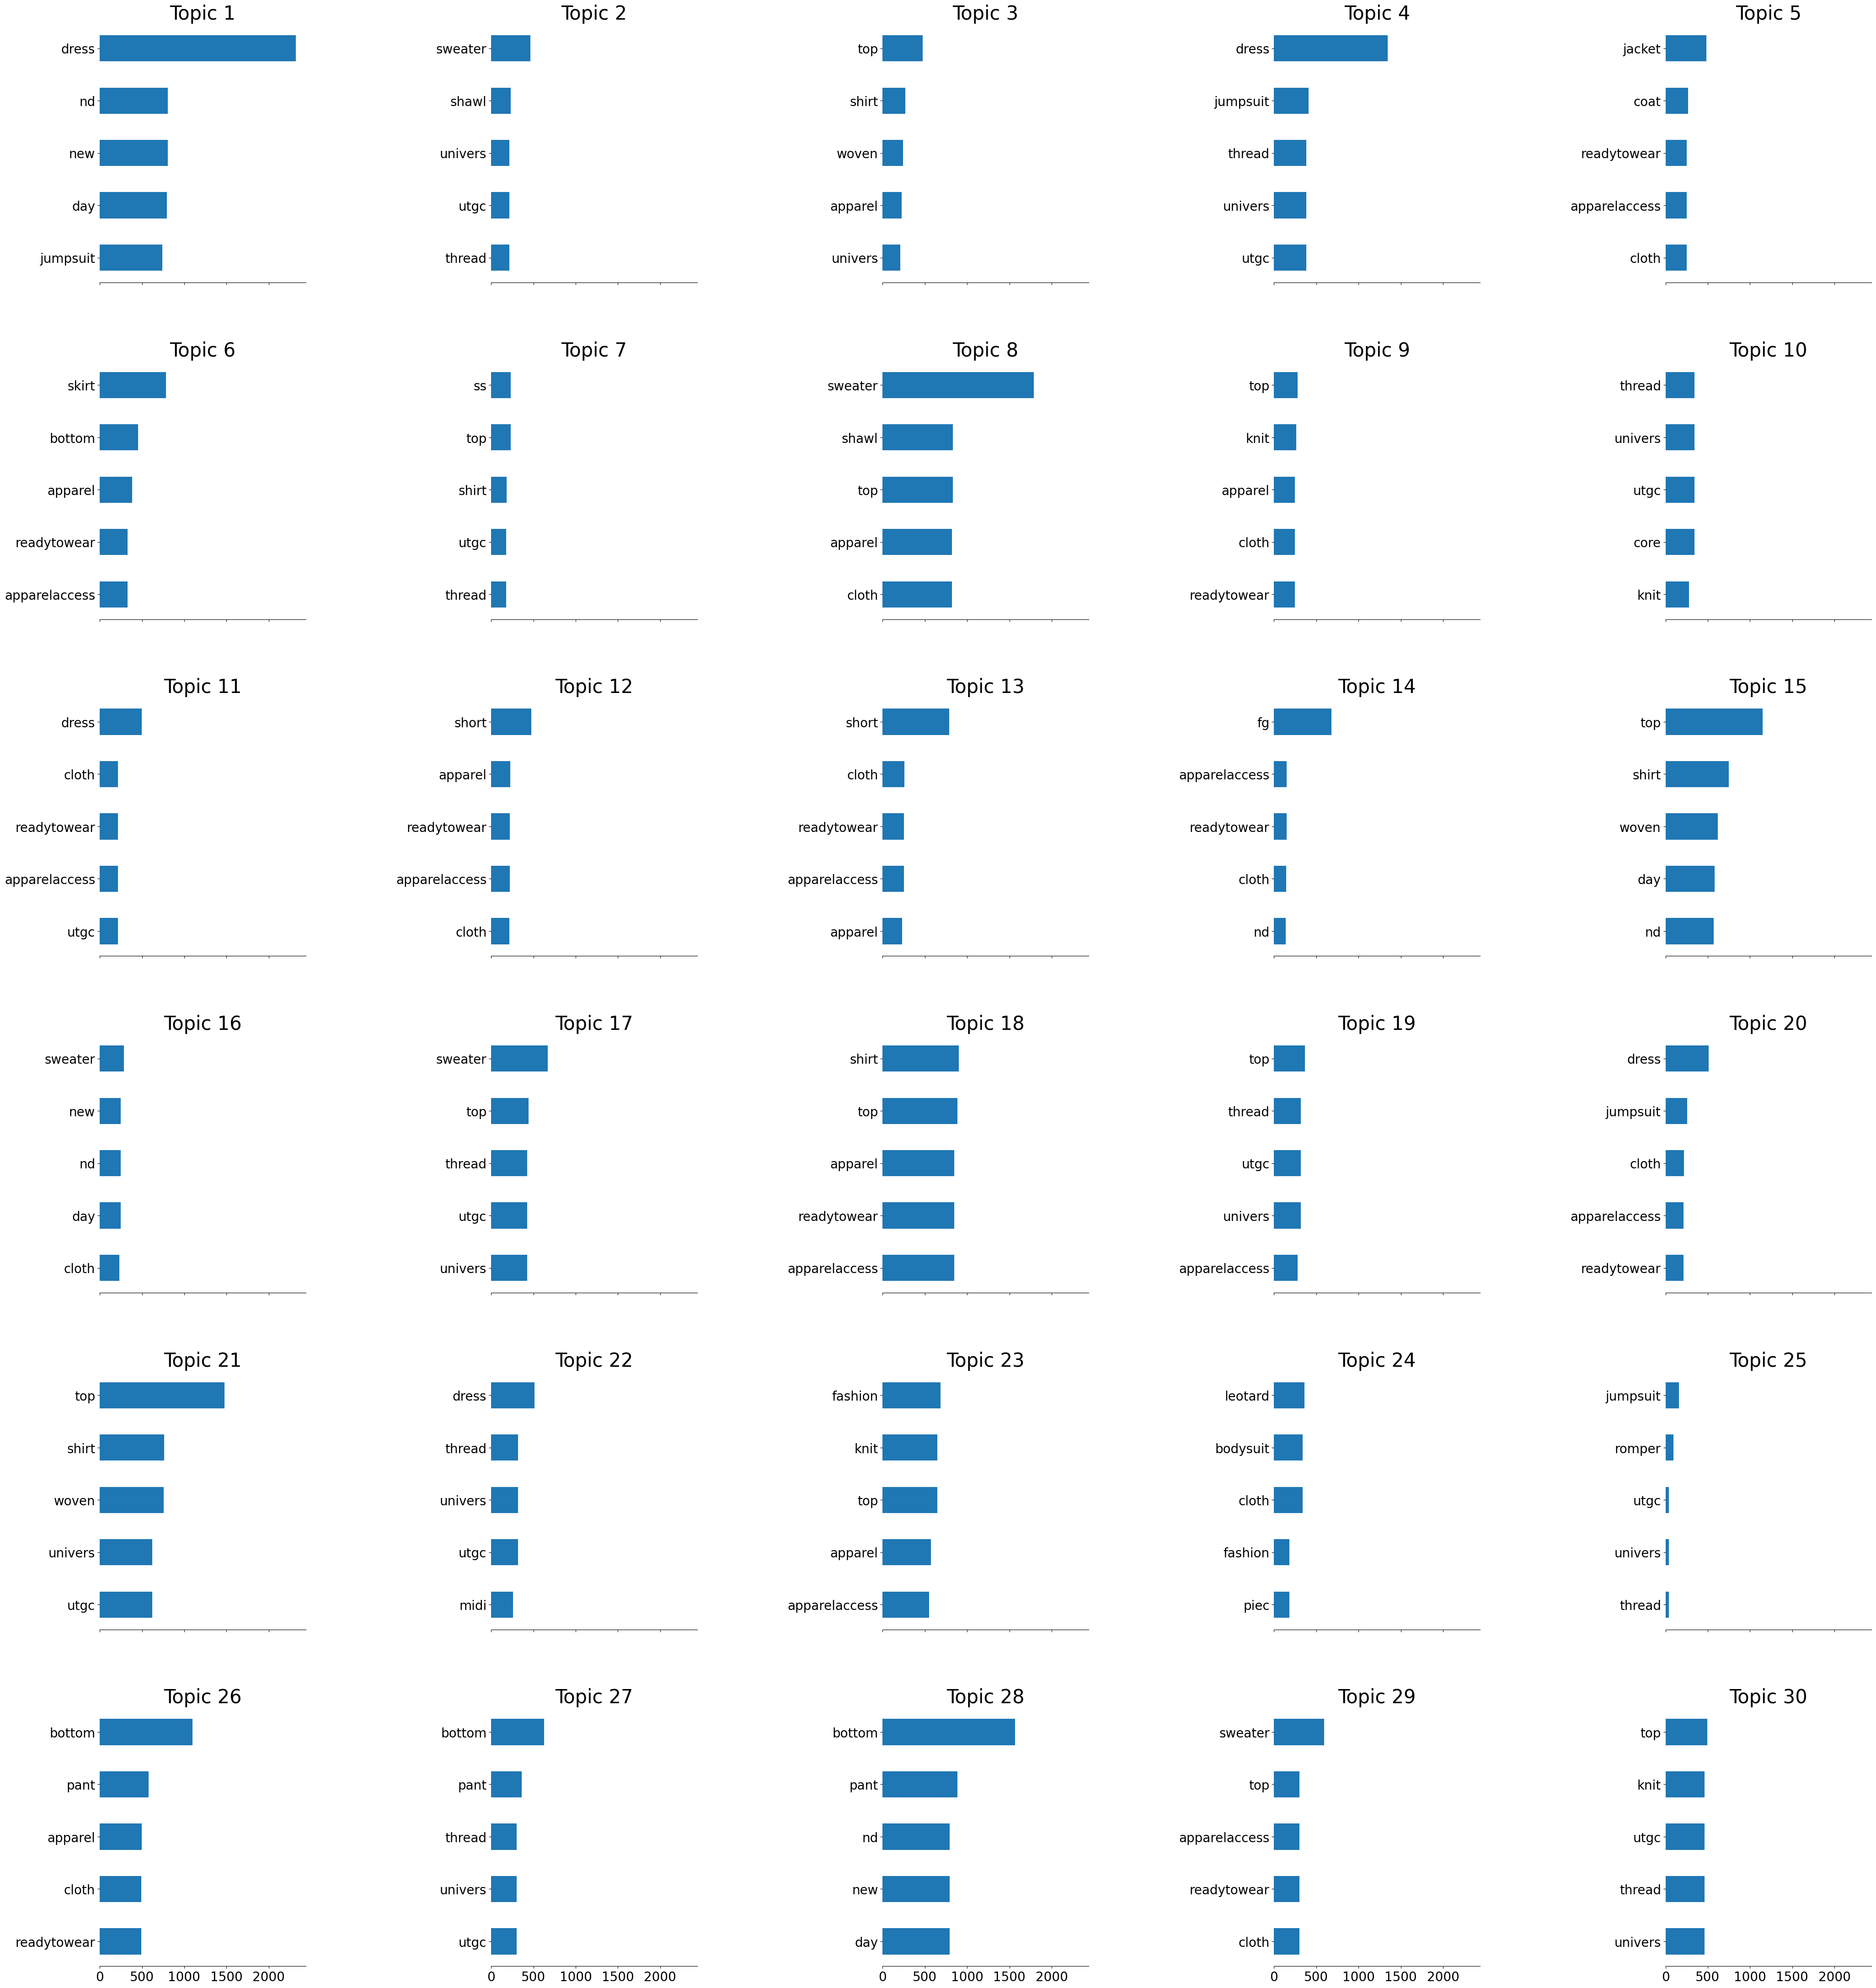

In [ ]:
#Remove stopwords, punctuation and numbers using gensim and string libraries

text2 = [remove_stopwords(x)\
        .translate(str.maketrans('','',string.punctuation))\
        .translate(str.maketrans('','',string.digits))\
        for x in text]

text3 = pd.Series([stemSentence(x) for x in text2])

#Bag of words
vectorizer_cv = CountVectorizer(analyzer='word')
X_cv = vectorizer_cv.fit_transform(text3)

#LDA identifies patterns in word frequency to probabilistically estimate topics of documents and words used in those topics.
lda = LatentDirichletAllocation(n_components=30, learning_decay=0.9)
X_lda = lda.fit(X_cv)

#Show topics
n_top_words = 5
feature_names = vectorizer_cv.get_feature_names_out()
plot_top_words(X_lda, feature_names, n_top_words, '')

# <font size=30px>Model Processing</font>
### We solve the problem in three stages.
1. K means Clustering based on fixed_attributes to determine the similar products
<br></br>
2. Text Similarity Computation using NLP toolkit- Spacy on preprocessed_data to find top most similar products in a cluster
<br></br>
3. Calculate sales impact and final score where final score gives us the confidence with which demand will be transferred to another item and possible sales impact on the item onto which demand is transferred.  

# K means Clustering
### We choose the number of clusters based on the <font color='blue'>'Elbow method'</font> with test increments of 100 clusters against  Sum of the Squared Euclidean distances of each point to its closest centroid.
### From the plot we understand that 200 clusters are required for optimal clustering.

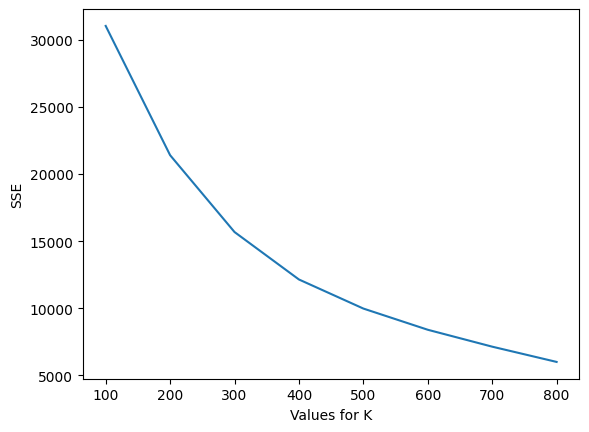

In [ ]:
visualize_clusters_required(text)

# <font size=30px>Outcome</font>

### Test case- 1

In [ ]:
number_of_clusters=200
tcin_to_remove=82567767
st = time.process_time()
indexed_clusters = data_clustering(df, text, number_of_clusters, tcin_to_remove)
final_data=get_sales_impact(indexed_clusters)
final_data = final_data[(final_data.text_similarity != 1.000000)]
et = time.process_time()
final_data.head(3)

,index,tcin,fixed_attributes,preprocessed_data,text_similarity,sales,score,sales_impact,final_score
2,1106,82567746,APPAREL/ACCESS READY-TO-WEAR UNIVERSAL THREAD ...,'womens''fitted''crossover''recycledcotton''80...,0.910905,896,0.914893,49.326243,0.740355
1,1100,82567716,APPAREL/ACCESS READY-TO-WEAR UNIVERSAL THREAD ...,'crossover''casual''tumbledry''adult18yearsand...,0.915332,286,0.621197,15.744761,0.480934
3,1112,82567756,APPAREL/ACCESS READY-TO-WEAR UNIVERSAL THREAD ...,'tumbledry''womens''round''crossover''colorful...,0.888090,169,0.538032,9.303722,0.349313


In [ ]:
print("Top 3 products with highest impcat upon removal of product with tcin = {} are:".format(tcin_to_remove))
print("We can say with {:.2f}% confidence that the sales of product with tcin={} will increase by {:.2f}%.".format(final_data.iloc[0][8]*100, final_data.iloc[0][1], final_data.iloc[0][7]))
print("We can say with {:.2f}% confidence that the sales of product with tcin={} will increase by {:.2f}%.".format(final_data.iloc[1][8]*100, final_data.iloc[1][1], final_data.iloc[1][7]))
print("We can say with {:.2f}% confidence that the sales of product with tcin={} will increase by {:.2f}%.".format(final_data.iloc[2][8]*100, final_data.iloc[2][1], final_data.iloc[2][7]))
print("Time taken to get top 3 products is {}".format(et - st))

Top 3 products with highest impcat upon removal of product with tcin = 82567767 are:
We can say with 74.04% confidence that the sales of product with tcin=82567746 will increase by 49.33%.
We can say with 48.09% confidence that the sales of product with tcin=82567716 will increase by 15.74%.
We can say with 34.93% confidence that the sales of product with tcin=82567756 will increase by 9.30%.
Time taken to get top 3 products is 16.78520500000002


### Test case- 2

In [ ]:
tcin_to_remove=82567760
st = time.process_time()
indexed_clusters = data_clustering(df,text,number_of_clusters, tcin_to_remove)
final_data=get_sales_impact(indexed_clusters)
final_data = final_data[(final_data.text_similarity != 1.000000)]
et = time.process_time()
final_data.head(3)

,index,tcin,fixed_attributes,preprocessed_data,text_similarity,sales,score,sales_impact,final_score
1,1110,82567750,APPAREL/ACCESS READY-TO-WEAR UNIVERSAL THREAD ...,'casual''nocollar''fitted'olidpatternapplied''...,0.948891,118,0.575009,3.254380,0.556763
5,1106,82567746,APPAREL/ACCESS READY-TO-WEAR UNIVERSAL THREAD ...,'womens''fitted''crossover''recycledcotton''80...,0.753039,896,0.782483,24.711226,0.536528
3,1113,82567757,APPAREL/ACCESS READY-TO-WEAR UNIVERSAL THREAD ...,'blouses''womens'olid''machinewash''tumbledry'...,0.769175,279,0.495352,7.694679,0.291364


In [ ]:
print("Top 3 products with highest impcat upon removal of product with tcin = {} are:".format(tcin_to_remove))
print("We can say with {:.2f}% confidence that the sales of product with tcin={} will increase by {:.2f}%.".format(final_data.iloc[0][8]*100, final_data.iloc[0][1], final_data.iloc[0][7]))
print("We can say with {:.2f}% confidence that the sales of product with tcin={} will increase by {:.2f}%.".format(final_data.iloc[1][8]*100, final_data.iloc[1][1], final_data.iloc[1][7]))
print("We can say with {:.2f}% confidence that the sales of product with tcin={} will increase by {:.2f}%.".format(final_data.iloc[2][8]*100, final_data.iloc[2][1], final_data.iloc[2][7]))
print("Time taken to get top 3 products is {}".format(et - st))

Top 3 products with highest impcat upon removal of product with tcin = 82567760 are:
We can say with 55.68% confidence that the sales of product with tcin=82567750 will increase by 3.25%.
We can say with 53.65% confidence that the sales of product with tcin=82567746 will increase by 24.71%.
We can say with 29.14% confidence that the sales of product with tcin=82567757 will increase by 7.69%.
Time taken to get top 3 products is 16.357201999999972


### Test case- 3

In [ ]:
tcin_to_remove=54387245
st = time.process_time()
indexed_clusters = data_clustering(df,text,number_of_clusters, tcin_to_remove)
final_data=get_sales_impact(indexed_clusters)
final_data = final_data[(final_data.text_similarity != 1.000000)]
et = time.process_time()
final_data.head(3)

,index,tcin,fixed_attributes,preprocessed_data,text_similarity,sales,score,sales_impact,final_score
46,2671,83813813,APPAREL/ACCESS READY-TO-WEAR UNIVERSAL THREAD ...,'medium''womens''100''tumbledry''quiltedpatter...,0.680453,6773.0,0.748696,0.916974,0.476288
9,2666,83813804,APPAREL/ACCESS READY-TO-WEAR UNIVERSAL THREAD ...,'casualfit''longsleeve''pointedcollar''frontbu...,0.768114,3255.0,0.609838,0.440684,0.412190
58,2672,83813814,APPAREL/ACCESS READY-TO-WEAR UNIVERSAL THREAD ...,'polyester''large''fairisledesign''coatsandjac...,0.648987,5489.0,0.648108,0.743138,0.348886


In [ ]:
print("Top 3 products with highest impcat upon removal of product with tcin = {} are:".format(tcin_to_remove))
print("We can say with {:.2f}% confidence that the sales of product with tcin={} will increase by {:.2f}%.".format(final_data.iloc[0][8]*100, final_data.iloc[0][1], final_data.iloc[0][7]))
print("We can say with {:.2f}% confidence that the sales of product with tcin={} will increase by {:.2f}%.".format(final_data.iloc[1][8]*100, final_data.iloc[1][1], final_data.iloc[1][7]))
print("We can say with {:.2f}% confidence that the sales of product with tcin={} will increase by {:.2f}%.".format(final_data.iloc[2][8]*100, final_data.iloc[2][1], final_data.iloc[2][7]))
print("Time taken to get top 3 products is {}".format(et - st))

Top 3 products with highest impcat upon removal of product with tcin = 54387245 are:
We can say with 47.63% confidence that the sales of product with tcin=83813813 will increase by 0.92%.
We can say with 41.22% confidence that the sales of product with tcin=83813804 will increase by 0.44%.
We can say with 34.89% confidence that the sales of product with tcin=83813814 will increase by 0.74%.
Time taken to get top 3 products is 16.210824000000002


### Test case- 4

In [ ]:
tcin_to_remove=83928463
st = time.process_time()
indexed_clusters = data_clustering(df,text,number_of_clusters, tcin_to_remove)
final_data=get_sales_impact(indexed_clusters)
final_data = final_data[(final_data.text_similarity != 1.000000)]
et = time.process_time()
final_data.head(3)

,index,tcin,fixed_attributes,preprocessed_data,text_similarity,sales,score,sales_impact,final_score
1,3540,83928776,APPAREL/ACCESS READY-TO-WEAR A NEW DAY ND BOTT...,'wideleg''70''rayon''flyzipper''frontpocket'ol...,0.955841,2427,0.599985,37.117862,0.567523
30,1428,82650441,APPAREL/ACCESS READY-TO-WEAR A NEW DAY ND BOTT...,'98''tumbledry''machinewash''nostretch''green'...,0.746406,21754,0.775167,332.699616,0.557217
2,1572,82708774,APPAREL/ACCESS READY-TO-WEAR A NEW DAY ND BOTT...,'highrise'kinny''100''leggings''fullwaistbande...,0.912100,4056,0.591621,62.031334,0.521104


In [ ]:
print("Top 3 products with highest impcat upon removal of product with tcin = {} are:".format(tcin_to_remove))
print("We can say with {:.2f}% confidence that the sales of product with tcin={} will increase by {:.2f}%.".format(final_data.iloc[0][8]*100, final_data.iloc[0][1], final_data.iloc[0][7]))
print("We can say with {:.2f}% confidence that the sales of product with tcin={} will increase by {:.2f}%.".format(final_data.iloc[1][8]*100, final_data.iloc[1][1], final_data.iloc[1][7]))
print("We can say with {:.2f}% confidence that the sales of product with tcin={} will increase by {:.2f}%.".format(final_data.iloc[2][8]*100, final_data.iloc[2][1], final_data.iloc[2][7]))
print("Time taken to get top 3 products is {}".format(et - st))

Top 3 products with highest impcat upon removal of product with tcin = 83928463 are:
We can say with 56.75% confidence that the sales of product with tcin=83928776 will increase by 37.12%.
We can say with 55.72% confidence that the sales of product with tcin=82650441 will increase by 332.70%.
We can say with 52.11% confidence that the sales of product with tcin=82708774 will increase by 62.03%.
Time taken to get top 3 products is 15.466182000000003


# <font size=30px>Future enhancement</font>
##  Due to unconscious biases raised due to multiple factors like launch date, off the shelf period, we see the variations in <font color='blue'>percentage increase</font> in sales impact, we plan to resolve this by standardization of sales data.